# Extract and compare DEM elevation with ICESat-2 Points
1. Merge DEMs strips is more than 1
2. Extract Elevation for DEM
3. Note Time and Time difference between acquisition of ICESat-2, DEM imagery, and if DEM composed of cross-track imageries

May 07, 2020  

In [1]:
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (12, 7), 'font.size': 10})

import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gpd
import xarray as xr
# import rasterio as rio

import hvplot
import geoviews as gv
import hvplot.pandas
import hvplot.xarray

In [3]:
# Choose Icesat-2 Product
short_name = 'ATL06'

# Setup data paths
region = 'region_02_greenland_southeast'
dir_prefix = '/fs/byo/howat-data5' #data4, 5 'D:' 'V:' '/fs/byo/howat-data4' #'/fs/project/howat.4' #/REMA/region_20_ross_shelf
dem_type = ['REMA', 'EarthDEM', 'ArcticDEM']
dem_type = dem_type[2] # MUST CHOOSE
# Here we will start to ICESat-2 because all of these have corresponding DEM folder
base_icesat2_path = f'/fs/project/howat.4/icesat2/{dem_type}/{region}_{short_name}' # Set the icesat2_path : where ICESat-2 files are staged
strips = os.listdir(base_icesat2_path)
# Select a particular satellite, WV03 for example
# strips = [strip for strip in strips if strip.startswith('WV03')]
len(strips)

782

In [4]:
# fig_folder = '/home/yadav.111/figs_icesat/ATL06'
analysis_folder = f'/fs/project/howat.4/icesat2/prototyping/analysis/{dem_type}/{region}'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

# strip = 'W1W1_20190416_1020010084CEDB00_1020010085562400_2m_lsf_v030403'
strip = strips[-2]
print(strip)
icesat2_path = f'{base_icesat2_path}/{strip}'
files = os.listdir(f'{icesat2_path}')

outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')


hdf_files = [f for f in files if f.endswith('.h5')]
shp_files = [f for f in files if f.endswith('.shp') and 'ATL06' in f]
csv_files = [f for f in files if f.endswith('.csv') and 'ATL06' in f]

WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_v040101


In [5]:
shp_files

['processed_ATL06_20191031235946_05360503_002_01.shp']

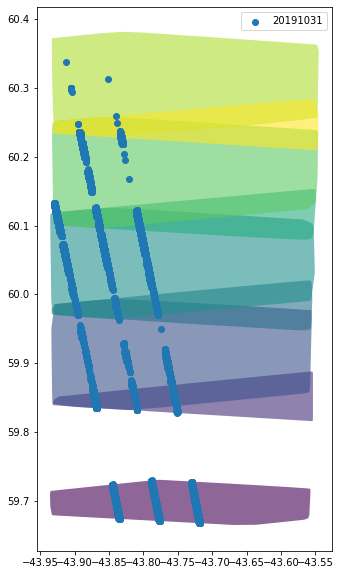

In [6]:
# Quick Check for Data
ax = outline.plot(column='seg_id', alpha=.6, lw=1, figsize=(10,10))
for shp in shp_files:
    gdf = gpd.read_file(f'{icesat2_path}/{shp}', parse_dates=True)
    lbl = shp.split('_')[2][:8] #pd.to_datetime(shp.split('_')[2][:8])
    gdf.plot(ax=ax, label=lbl)
plt.legend(loc=1);

In [7]:
# Pick the largest granule for quick visualization only
sz_list = [os.path.getsize(f'{icesat2_path}/{hdf}') for hdf in hdf_files]
idx = sz_list.index(max(sz_list)) #largest index
print('No of shp files',len(shp_files), len(hdf_files))
# print(outline.area)

fname = shp_files[idx].split('.shp')[0]

No of shp files 1 1


In [8]:
shp_files

['processed_ATL06_20191031235946_05360503_002_01.shp']

## Choose a corresponding DEM Strip for Analysis

Some metadata info about DEMs and Orthos
https://www.pgc.umn.edu/guides/arcticdem/data-description/#section-3  
_matchtag.tif – Bitmask raster indicating DEM pixels derived from a stereo match (1) or those that have been interpolated (0)
0 edge 1 1
1 water 1 0
2 cloud 1 0


In [9]:
## Now get the DEM (Rema for example)

# strip_version = ['v4', 'unf']
# strip_version = strip_version[0] #choose based on how folder names look

# strips_folder = f'{dir_prefix}/{dem_type}/{region}/strips_v4/2m' #f'{dir_prefix}/EarthDEM/{region}/strips_unf/2m' #for Alaska but not tried yet as ATL06 does not exist for this region
# strips = os.listdir(f'{strips_folder}') Done use this, use the ones got from icesat-2 listing

# strips_folder = f'' #f'{dir_prefix}/EarthDEM/{region}/strips_unf/2m' #for Alaska but not tried yet as ATL06 does not exist for this region
# dem_folder =    f'{strips_folder}/{strip}'
# dem_folder = f'{dir_prefix}/{REMA}/{region}/strips_unf/2m/{strip}'
dem_folder =    f'{dir_prefix}/{dem_type}/{region}/strips_v4/2m/{strip}'
tifs = [tif for tif in os.listdir(dem_folder) if tif.endswith('.tif')]
tifs

['WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg3_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg5_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg7_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg8_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg1_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg6_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg4_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg5_ortho.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg9_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg7_ortho.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg8_ortho.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg2_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg3_ortho.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf

In [10]:
dem_folder

'/fs/byo/howat-data5/ArcticDEM/region_02_greenland_southeast/strips_v4/2m/WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_v040101'

In [11]:
outline#.name.values[0]#==outline.name.values[1]

name           time1  \
0  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170105   
1  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170105   
2  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170104   
3  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170104   
4  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170103   
5  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170103   
6  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170102   
7  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170101   
8  WV01_20191023_102001008DDFC500_102001008A969D0...  20191023170102   

            time2  seg_id                                           geometry  
0  20191023170154       1  POLYGON ((-43.90164 59.67732, -43.93159 59.678...  
1  20191023170153       2  POLYGON ((-43.55367 59.88652, -43.55366 59.821...  
2  20191023170153       3  POLYGON ((-43.55529 59.96661, -43.55760 59.873...  
3  20191023170152       4  POLYGON ((-43.93319 59.97760, -43.92973 59.985...  
4  20191023170152       5  POLYGON ((-43.84644 59.96406, -43.88629 59.966...  
5  20191023170151       6  POLYGON ((-43.54945 60.13555, -43.55264 60.088...  
6  20191023170151       7  POLYGON ((-43.93279 60.23037, -43.93227 60.244...  
7  20191023170150       8  POLYGON ((-43.54525 60.35286, -43.54702 60.258...  
8  20191023170150       9  POLYGON ((-43.92064 60.25203, -43.88026 60.255...

In [12]:
# Load ATL parsed data
df = pd.read_csv(f'{icesat2_path}/{fname}.csv', parse_dates=True)
gdf = gpd.read_file(f'{icesat2_path}/{fname}.shp', parse_dates=True)
# Pick only the good quality data [verify if zero or one means good]
df = df[df.q_flag==0]
gdf = gdf[gdf.q_flag==0]
df = df.reset_index(drop=True)
gdf = gdf.reset_index(drop=True)
#Also reset index
gtls = list(df.strip.unique())
print(len(df), gtls)
# gv.tile_sources.ESRI * gdf.hvplot.points(geo=True, color='strip', alpha=0.7, width=500, height=700, hover=['strip', 'h_te_media'])

3704 ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']


In [13]:
base = gv.tile_sources.ESRI
gtracks = gdf.hvplot.points(geo=True, color='strip', s=10, alpha=0.7, width=500, height=600)
terrain_scatter = df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters').relabel('Elevation') # by='strip', 
fig1 = base * gtracks + terrain_scatter
# hvplot.save(fig1, f'{analysis_folder}/test.png') #now working newly due to path for firefox or chromium
# fig1

In [14]:
# Some dems has gaps in between segments, eg: /fs/byo/howat-data5/ArcticDEM/region_02_greenland_southeast/strips_v4/2m/W1W2_20190428_102001008466F300_1030010090702200_2m_lsf_v040002
# so icesat-2 will has gaps as well; to make it contineous 
base * gtracks * outline.hvplot(geo=True, color='seg_id', alpha=.4)+ terrain_scatter

:Layout
   .Overlay.I           :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Points.I   :Points   [Longitude,Latitude]   (strip)
      .Polygons.I :Polygons   [Longitude,Latitude]   (seg_id)
   .NdOverlay.Elevation :NdOverlay   [strip]
      :Scatter   [h_li]   (lat)

In [15]:
base * outline.iloc[:2].hvplot(geo=True, color='seg_id', alpha=.8)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (seg_id)

In [16]:
# df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters', subplots=True)

In [17]:
# If there is more than one DEM, find a way to merge them into one seamless DEM
segments = [tif.split('_')[-2] for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]
segments.sort() #This is inplace sorting

In [18]:
segments

['seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8', 'seg9']

In [19]:
dem_tif = [tif.split('_seg')[0] for tif in os.listdir(dem_folder)] # if tif.endswith('_dem.tif')
dem_tif

['WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf

In [20]:
set(dem_tif) - set(['WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_v040101'])

{'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf'}

In [21]:
'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf' == 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf'


True

In [22]:
'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf'=='WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf'
# 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_v040101'

True

In [23]:
'_'.join(strip.split('_')[:-1])

'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf'

In [65]:
dem_prefix = '_'.join(strip.split('_')[:-1])
dem_prefix

'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf'

In [68]:
dem_prefix = f'{dem_folder}/{dem_prefix}_{segments[3]}'
dem_prefix

'/fs/byo/howat-data5/ArcticDEM/region_02_greenland_southeast/strips_v4/2m/WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_v040101/WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg4'

In [70]:
# dem_folder + '/' + dem_prefix + segments[0]
# dem_tif = f'{dem_folder}/{dem_prefix}_{segments[2]}_dem.tif'
dem_tif = f'{dem_prefix}_dem.tif'
matchtag_tif = f'{dem_prefix}_matchtag.tif'
os.path.exists(dem_tif), os.path.exists(matchtag_tif)

(True, True)

In [71]:
os.listdir(dem_folder)[:5]

['WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg3_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg5_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg7_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg8_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg1_dem.tif']

In [36]:
# Can have one or more DEMs depending on how it was produced
segment_index = 1
dem_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]
ortho_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_ortho.tif')][segment_index]
matchtag_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_matchtag.tif')][segment_index] #This is binary raster with values 0 = bad; and 1= good perhaps
# bitmask_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_bitmask.tif')][segment_index] #here 1 seems to be the nodata part even though attrs give a value of zero

print(dem_tif)
dem_tif = dem_tif[segment_index] #Choose one DEM (or better find a way to merge; but this will also significantly increase the size of data)

In [43]:
dem_tif

In [63]:
[tif for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]

['WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg3_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg5_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg7_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg8_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg1_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg6_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg4_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg9_dem.tif',
 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg2_dem.tif']

In [47]:
dem_tif.replace('dem', 'matchtag')

'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg5_matchtag.tif'

In [44]:
matchtag_tif

'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg8_matchtag.tif'

'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg5_dem.tif'

In [57]:
time_diff = pd.to_datetime(dem_tif.split('_')[1]) - pd.to_datetime(fname.split('_')[2])
time_diff

Timedelta('-9 days +00:00:14')

## Use Xarray load and analyze DEM

In [73]:
dem = xr.open_rasterio(dem_tif) #, chunks={'x':2**11, 'y':2**11}
dem = dem.load()
# da = xr.open_rasterio(f'{dem_folder}/{ortho_tif}')

In [74]:
nodata_value = dem.attrs['nodatavals'][0]
dem.data[dem.data==nodata_value] = np.nan # dem.datareplace no-data with NANs
print(nodata_value)

-9999.0


In [75]:
dem_tif

'/fs/byo/howat-data5/ArcticDEM/region_02_greenland_southeast/strips_v4/2m/WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_v040101/WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_seg4_dem.tif'

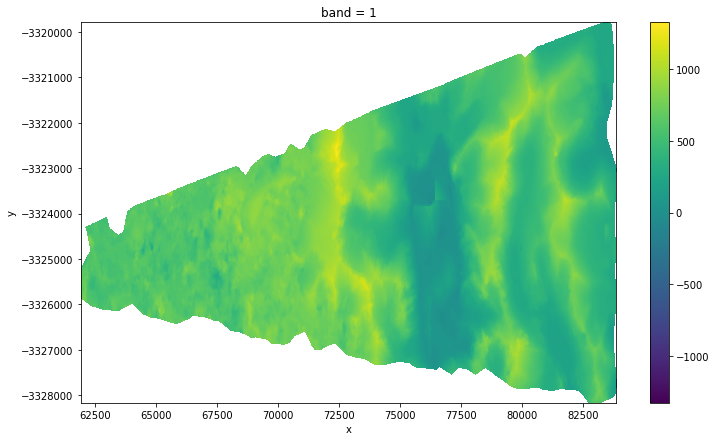

In [76]:
dem.sel(band=1).plot.imshow(cmap='viridis');

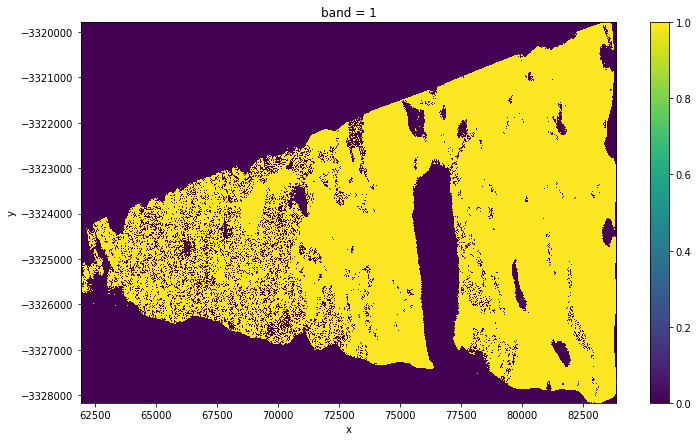

In [77]:
matchtag = xr.open_rasterio(matchtag_tif) #xr.open_rasterio(f'{dem_folder}/{matchtag_tif}').load()
matchtag.sel(band=1).plot.imshow();
# bitmask = xr.open_rasterio(f'{dem_folder}/{bitmask_tif}').load()

In [78]:
# Mask out problematic DEM values based matchtag mask [remove value = 0 or keep value == 1]; ie, put NANs whereever matchtag NOT == 1
dem = dem.where(matchtag.data==1) # or, matchtag.data

In [80]:
# matchtag.where(matchtag.data==1) # or, matchtag.data

In [81]:
# dem.sel(band=1).plot.imshow(cmap='viridis');
dem.sel(band=1).data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [82]:
# Change Icesat shapefile projection to match DEM's projection
# Else can't extract elevation from DEM
# Required to overlay plots as well
proj4 = dem.crs #dem.projection.ExportToProj4() # but there is extra space at the end
gdf1 = gdf.to_crs(proj4) 
# gdf1.iloc[1].geometry.x, gdf1.iloc[1].geometry.y

In [83]:
len(gdf1)

3704

## Extraction pixel value from raster for each point

In [84]:
def getPixVal(pt):
    """ Given a Geopandas/Shapely Point geometry, extract the pixel value from the Xarray raster """
    #x, y = pt.coords[:][0]
    out = dem.sel(x = pt.x, y=pt.y, method='nearest')
    return out.values[0]

In [85]:
gdf1['dem'] = gdf1.geometry.apply(getPixVal)

In [86]:
nan_count = len(gdf1[np.isnan(gdf1.dem)])
print(nan_count)
print('Nans Fraction: ',nan_count/len(gdf1))

3670
Nans Fraction:  0.9908207343412527


In [87]:
gdf1 = gdf1.dropna() #Drop the Nans from the edges of DEM
gdf1['dif'] = gdf1.h_li - gdf1.dem
gdf1 = gdf1.drop(['t_dt', 'q_flag'], axis=1)

In [88]:
len(gdf1), len(gdf)

(34, 3704)

In [89]:
gdf1.strip.value_counts()

gt1r    23
gt2r     7
gt3r     4
Name: strip, dtype: int64

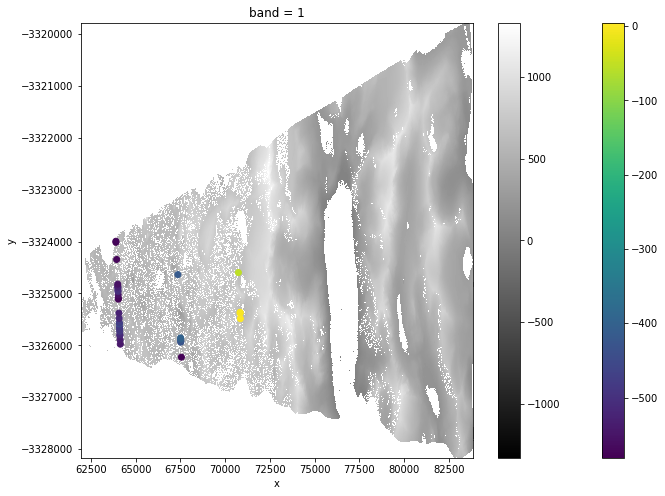

In [90]:
# da.plot.imshow(cmap='gist_earth')
ax = gdf1.plot(column='dif', legend=True, figsize=(11, 8))
# ax = gdf1.plot(column='dif', legend=True, figsize=(11, 8))

dem.sel(band=1).plot.imshow(ax=ax, cmap='gray');

In [91]:
gdf1.tail(2)

h_li strip                        geometry         dem        dif
3381  608.214233  gt3r  POINT (70832.072 -3325363.016)  610.007935  -1.793701
3382  621.482666  gt3r  POINT (70738.045 -3324598.679)  675.724915 -54.242249

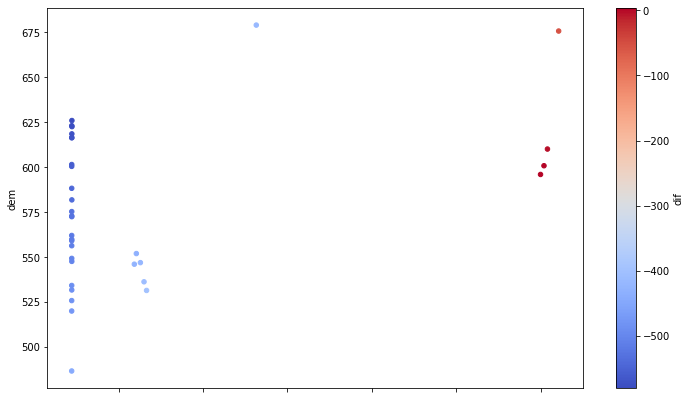

In [92]:
gdf1[['h_li','dem', 'dif']].plot(kind='scatter', x=0, y=1, c='dif', cmap='coolwarm');

In [93]:
# df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters', subplots=True)

In [94]:
# gdf1[['h_li','dem']].hvplot(kind='scatter', x=0, y=1);
gdf1[['h_li','dem', 'strip']].hvplot(y='dem', x='h_li', kind='scatter', by='strip', subplots=True)

:NdLayout   [strip]
   :Scatter   [h_li]   (dem)

In [95]:
gdf1[gdf1.strip=='gt3r'][['h_li','dem']].hvplot(kind='scatter', alpha=.5)

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

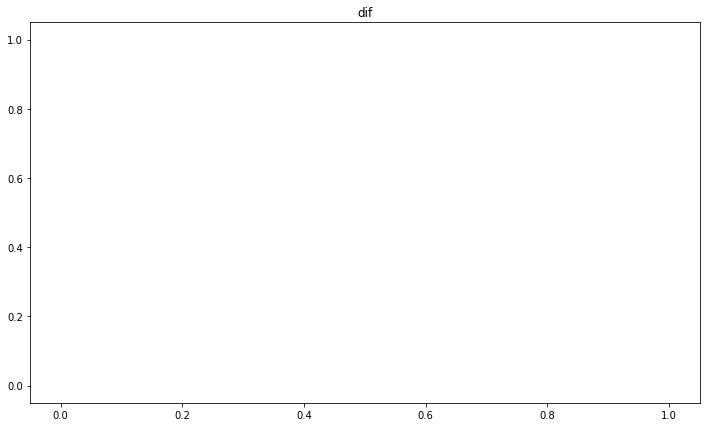

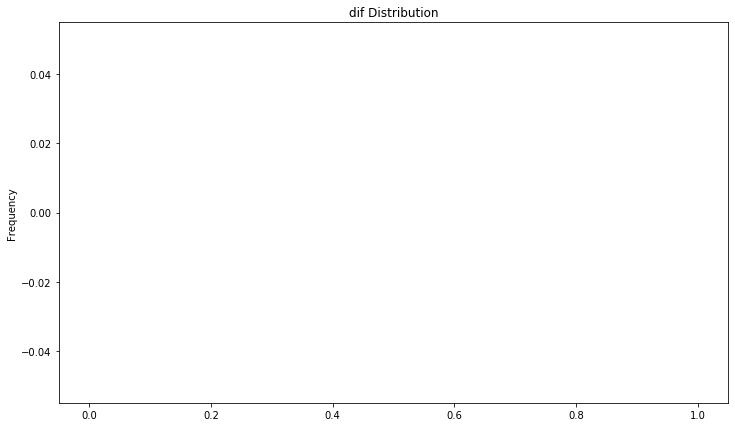

In [96]:
gdf1[gdf1.strip=='gt2l'].dif.plot(title='dif')
plt.figure()
gdf1[gdf1.strip=='gt2l'].dif.plot(kind='hist', bins=100, title='dif Distribution');

In [79]:
# ortho_tif
ortho = xr.open_rasterio(f'{dem_folder}/{ortho_tif}').load()
nodata_value = ortho.attrs['nodatavals'][0]
# First conver to fload, so it can be converted to nan
ortho.data = ortho.data.astype(float)

ortho.data[ortho.data==nodata_value] = np.nan
print(nodata_value)

0.0


In [80]:
np.nanmax(ortho.data)

2017.0

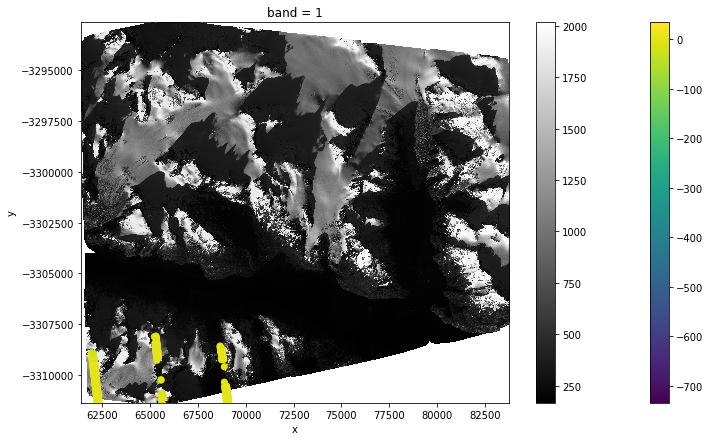

In [81]:
ax = gdf1.plot(column='dif', legend=True)
ortho.sel(band=1).plot.imshow(ax=ax, cmap='gray'); #, cmap='gist_earth'

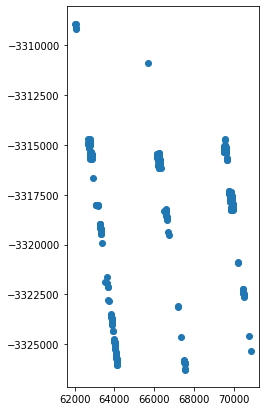

In [82]:
gdf1[np.abs(gdf1.dif)>7].plot();

In [83]:
# gdf2 = gdf1.reset_index(drop = True)

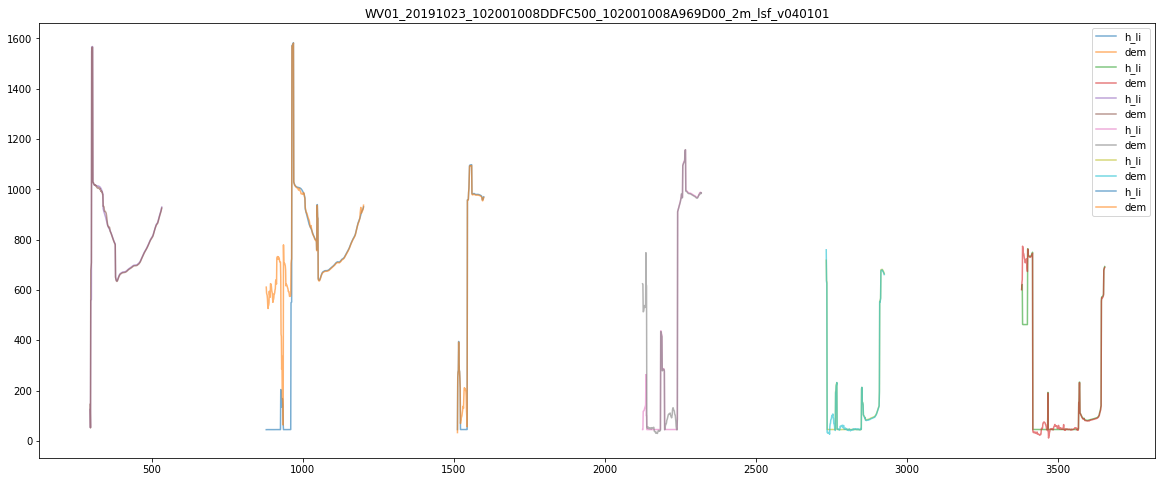

In [84]:
gtls = list(gdf1.strip.value_counts().index) #['gt1l', 'gt1r','gt2l', 'gt2r', 'gt3l','gt3r']
# gtl = gtls[2]
fig, ax = plt.subplots(figsize=(20, 8))
for gtl in gtls:
    gdf1[gdf1.strip==gtl][['h_li', 'dem']].iloc[1:-1].plot(style='-', alpha=.6, title=strip, ax=ax);

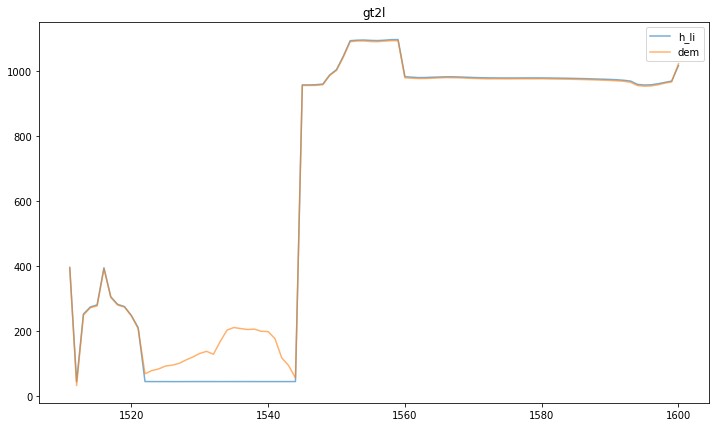

In [85]:
gdf1[gdf1.strip==gtl][['h_li', 'dem']].plot(style='-', alpha=.6, title=gtl);

In [86]:
# gdf1[gdf1.strip==gtl].reset_index()[['h_li', 'dem']].plot(style='-', alpha=.6, title=gtl);

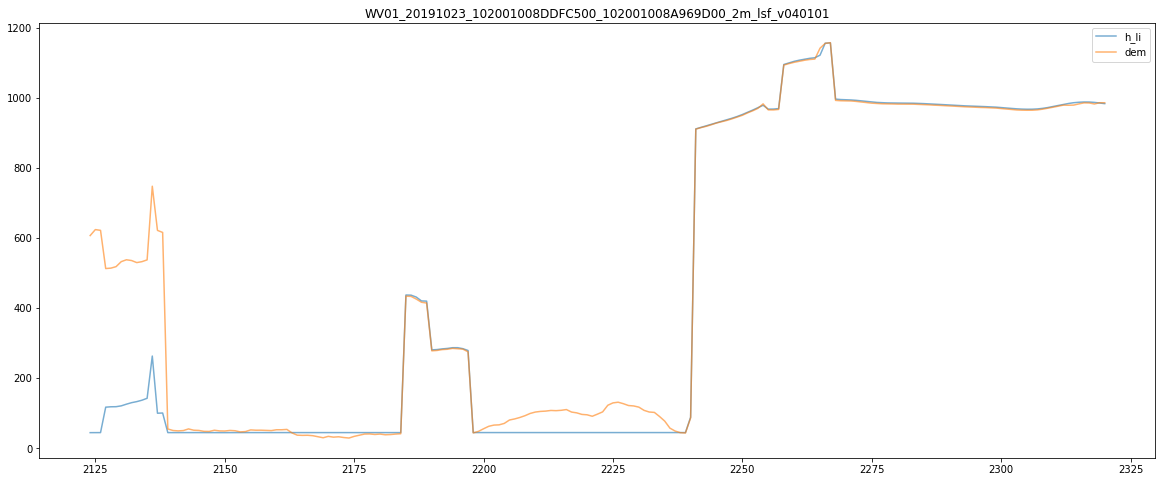

In [87]:
# gdf[['h_li', 'dem']].plot()
fig, ax = plt.subplots(figsize=(20, 8))
# gdf2[gdf2.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax
gdf1[gdf1.strip==gtls[3]][['h_li', 'dem']].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

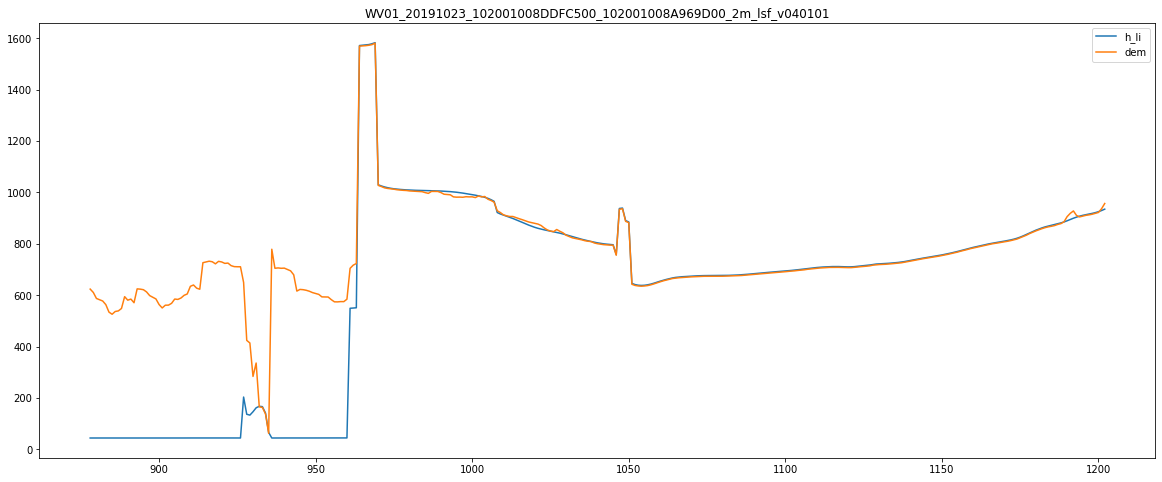

In [88]:
fig, ax = plt.subplots(figsize=(20, 8))
# gdf1[gdf1.strip==gtls[0]][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', title=strip, ax=ax); #, ax=ax
gdf1[gdf1.strip==gtls[0]][['h_li', 'dem']].plot(style='-', title=strip, ax=ax); #, ax=ax

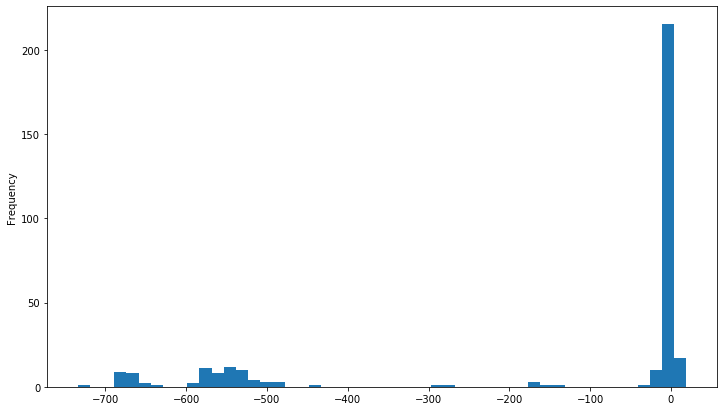

In [89]:
gdf1[gdf1.strip==gtls[0]].dif.plot(kind='hist', bins=50);

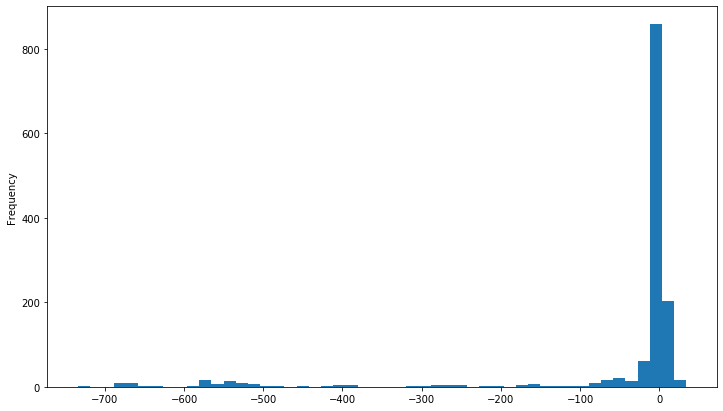

In [90]:
gdf1.dif.plot(kind='hist', bins=50);

In [91]:
gdf1.dif.mean()

-45.49033363558211

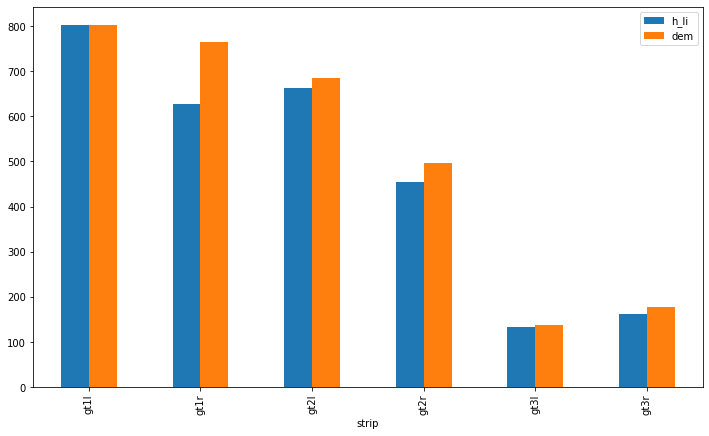

In [92]:
dfg = gdf1.groupby('strip')
# dfg.dif.mean().plot(kind='bar');
dfg[['h_li', 'dem']].mean().plot(kind='bar');

In [78]:
# gtl = 'gt2'
# ax = gdf1[gdf1.strip==f'{gtl}l'][['dem','h_li']].plot(lw=4, alpha=.5)
# gdf2[gdf2.strip==f'{gtl}r'][['h_li', 'dem']].plot(ax = ax)